# Monte Carlo Methods

## Computing $\pi$
##### Hello World: Monte Carlo Edition

* $x,y \sim \mathcal{U_{[-1,1]}}.$
* Area of the square: $A_\square=4$
* Area of the circle: $A_O = \pi$
    * Is the sampled point inside of the the circle ($x^2 + y^2 < 1$)? 

Random Variable $X(\omega)$ = 1 .... point $x,y$ inside of circle, $X(\omega)$ = 0 otherwise

$P(X) = \frac{A_O}{A_\square} = \frac{\pi}{4}$

interactive(children=(IntSlider(value=1, description='n', max=10000, min=1), Output()), _dom_classes=('widget-…

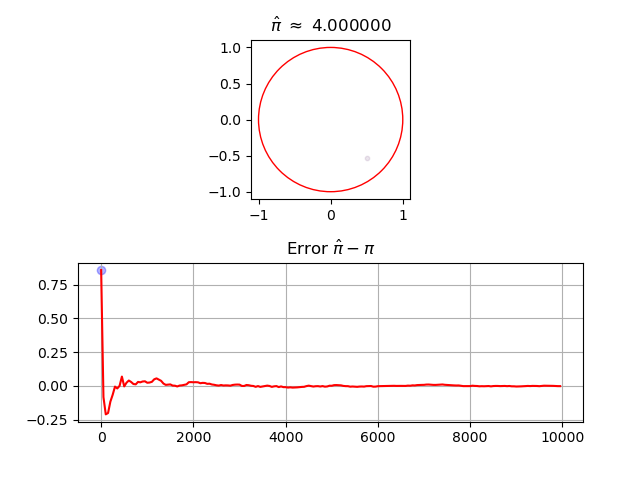

In [122]:
%matplotlib widget

from ipywidgets import *
import numpy as np

import matplotlib.pyplot as plt

num_samples = 10000

x = np.random.uniform(low=-1, high=1, size=num_samples)
y = np.random.uniform(low=-1, high=1, size=num_samples)
c = x**2 + y**2 < 1


fig, axes = plt.subplots(2, 1)
ax = axes[0]
er = axes[1]
er.set_xlim(0, num_samples)
er.set_ylim(-0.3,0.3)
fig.tight_layout(pad=2.5)

circle = plt.Circle((0, 0), 1, color='r',fill=False)

pi_t = [4*((sum(c[:i])/i))-np.pi for i in range(1,num_samples, 50)]

@widgets.interact(n=(1, num_samples, 1))
def update(n = 1):
    ax.clear()
    er.clear()
    er.grid('on')


    ax.set_aspect('equal')
    ax.scatter(x[:n], y[:n], c=c[:n], alpha=0.1, s=10)
    ax.add_patch(circle)

    pi_hat = 4*((sum(c[:n])/n))
    ax.set_title(r"$\hat{\pi}$ $\approx$ " + f"{pi_hat:.6f}")

    
    er.plot(range(1,num_samples, 50), pi_t, '-r')
    er.scatter(n, pi_hat-np.pi, alpha=0.3, c='blue')
    er.set_title(r"Error $\hat{\pi}-\pi$")


## Expected Value

$$
\bar{X} = E(X) = \sum_{s \in S} p(s)X(s)\\
\text{"What are we going to get on average?"}\\
$$


## Variance


$$
Var[X] = E[(X - \bar{X})^2]\\
\text{"How tightly clustered will my results be?"}\\
$$



# Rejection Sampling 

pretty cool how we can actually draw from different distr.
basic idea: 
* take distr that we know how to draw from
* scale it over the Distr we want to sample from
* Reject samples that are above D(x)
# Importance Sampling

show S f(x) * p(x)/q(x) * q(x) <---- tractable since we can choose q(x)